In [151]:
#### %matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline
from __future__ import division

import numpy as np
import pandas as pd
import random
from random import randint

Populating the interactive namespace from numpy and matplotlib


In [108]:
def levy(r0, a, k, r):
    return exp(-r/k)*(r + r0)**(-a)

In [87]:
r0 = 100  ## Distance between cells
a = 2
k = 1500

In [72]:
gs = 5 ## Cells per side
S = gs*gs ## Grid Size
nc = 100 ## Number of habitants per cells
N = nc*S

In [73]:
d = []
I = []
J = []
c = []
X = []
Y = []
count = 0
for i in range(0, S):
    for j in range(0, S):
        if i == j: continue
        x1,x2 = i%gs, j%gs
        y1,y2 = i//gs, j//gs
        dist = sqrt( float(x1-x2)**2 + float(y1-y2)**2)  # pythagoras theorem
        #dist = abs(x1-x2) + abs(y1-y2)
        dist *= r0
        d.append(dist)
        I.append(i)
        J.append(j)
        

In [139]:
max(df['d'])

565.685424949238

In [74]:
df = pd.DataFrame()
df['i']=I
df['j']=J
df['d']=d
df.head()

,i,j,d
0,0,1,100.0
1,0,2,200.0
2,0,3,300.0
3,0,4,400.0
4,0,5,100.0


In [153]:
r = 1
p = []
R = []
for i in range(0,60000):
    R.append(r)
    p.append(levy(r0, a, k, r)*10000)
    r+=.01

In [155]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [163]:
dr = np.array(R)
dp = np.array(p)

In [206]:
nc

100

In [211]:
nagents = np.arange(0,N)
cell = 0
hc = []
wc = []
upd = nc
same = int(0.2*nc)
MR = np.zeros((gs, gs))
for i in range(0, S):  ### For all the cell
    for j in range(0,nc): ## For each agent in the cell
        hc.append(cell)
        if j < same:  ## First 20 assign same home/work cell
            wc.append(cell)
        else:
            rand = random.uniform(0, 1)
            fd = find_nearest(dp, rand)
            wx = np.where(dp==fd)
            dx = R[wx[0][0]]
            tmp = df[df['i']==cell]
            ft = find_nearest(tmp['d'], dx)
            tmp = tmp[tmp['d']==ft]
            k = randint(0,len(tmp)-1)
            idx = tmp.index[k]
            wc.append(tmp['j'][idx])
    cell+=1

In [212]:
net = pd.DataFrame()
net['home']=hc
net['work']=wc
net.to_csv()

,home,work
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


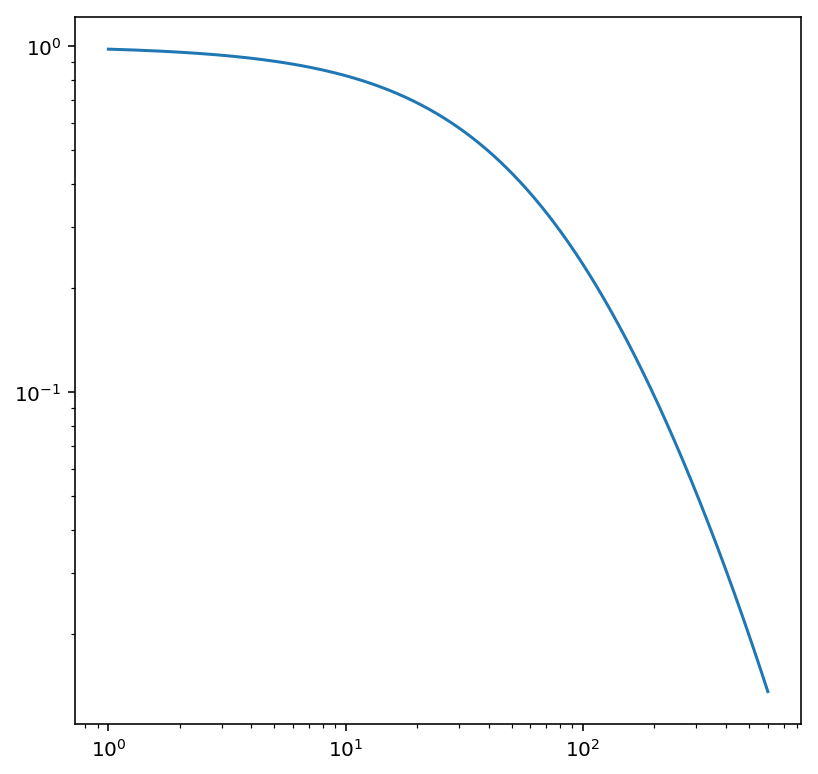

In [147]:
fig,ax = plt.subplots(figsize=(6.5,6.5))
plt.plot(R,p)
ax.set_xscale('log')
ax.set_yscale('log')